In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
from nltk.corpus import stopwords
# nltk.download('stopwords')
from collections import Counter
from sklearn import model_selection, feature_extraction, metrics
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


Import data set:


In [319]:
pd.options.mode.chained_assignment = None

col_list = ['text', 'class']
df_full = pd.read_csv('data/data_set.csv', usecols=col_list)
df = df_full[['text']]

df["text"] = df["text"].astype(str)
df_full.head()
df.head()


,text
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ..."
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο..."
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν..."
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη..."
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ..."


# Text preprocessing:


## lower casing:


In [320]:

df["text_lower"] = df["text"].str.lower()
df.head()
# drop the new column created in last cell
# df.drop(["text_lower"], axis=1, inplace=True)


,text,text_lower
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ..."
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο..."
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν..."
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη..."
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ..."


## remove punctuation


In [321]:
punctuation = '«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'
PUNCT_TO_REMOVE = punctuation


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...


## remove stopwords:


In [322]:
STOPWORDS_GREEK = set(stopwords.words('greek'))


def import_additional_greek_stopwords(STOPWORDS_GREEK):
    STOPWORDS_GREEK.add('της')
    STOPWORDS_GREEK.add('από')
    STOPWORDS_GREEK.add('είναι')
    STOPWORDS_GREEK.add('έχει')
    STOPWORDS_GREEK.add('σας')
    STOPWORDS_GREEK.add('τους')
    STOPWORDS_GREEK.add('τη')
    STOPWORDS_GREEK.add('μας')
    STOPWORDS_GREEK.add('στα')
    STOPWORDS_GREEK.add('στις')
    STOPWORDS_GREEK.add('στους')
    STOPWORDS_GREEK.add('μου')
    STOPWORDS_GREEK.add('σου')
    return STOPWORDS_GREEK


STOPWORDS_GREEK = import_additional_greek_stopwords(STOPWORDS_GREEK)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS_GREEK])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...


## remove intonation:


In [323]:
def remove_intonation(text):

    rep = {"ά": "α", "έ": "ε", "ή": "η", "ί": "ι", "ό": "ο", "ύ": "υ", "ώ": "ω", "ϊ": "ι",
           "ἀ": "α", "ἐ": "ε", "ἤ": "η", "ἰ": "ι", "ἄ": "α", "ὐ": "υ", "ὡ": "ω", "ὦ": "ω",
           'ὖ': 'υ', 'ὅ': 'ο', 'ῆ': 'η', 'ῇ': 'η', 'ῦ': 'υ', 'ὁ': 'ο', 'ὑ': 'υ', 'ὲ': 'ε',
           'ὺ': 'υ', 'ἂ': 'α', 'ἵ': 'ι', 'ὴ': 'η', 'ὰ': 'α', 'ἅ': 'α', 'ὶ': 'ι', 'ἴ': 'ι',
           'ὸ': 'ο', 'ἥ': 'η', 'ἡ': 'η', 'ὕ': 'υ', 'ἔ': 'ε', 'ἳ': 'ι', 'ὗ': 'υ', 'ἃ': 'α',
           'ὃ': 'ο', 'ὥ': 'ω', 'ὔ': 'υ', 'ῖ': 'ι', 'ἣ': 'η', 'ἷ': 'ι', 'ἑ': 'ε', 'ᾧ': 'ω',
           'ἢ': 'η', 'ΐ': 'ι', }

    rep = dict((nltk.re.escape(k), v) for k, v in rep.items())
    pattern = nltk.re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[nltk.re.escape(m.group(0))], text)

    return text


df["text_wo_intonation"] = df["text_wo_stop"].apply(
    lambda text: remove_intonation(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...,συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...


## remove frequent words:


### get most frequent words:


In [324]:
cnt = Counter()
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten more frequent elements:
cnt.most_common(10)


[('οτι', 969),
 ('ειχε', 564),
 ('μια', 515),
 ('ηταν', 427),
 ('συμφωνα', 374),
 ('ενω', 365),
 ('ενα', 356),
 ('αλλα', 356),
 ('δυο', 327),
 ('οπως', 325)]

### remove most frequent words:


In [325]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])


def remove_freqwords(text):
    """custom function to remove frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])


df["text_wo_freq"] = df["text_wo_intonation"].apply(
    lambda text: remove_freqwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop,text_wo_intonation,text_wo_freq
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...","""μ.βεργ. έναν μήνα αφότου η τουρκία αποχώρησε ...",μβεργ έναν μήνα αφότου η τουρκία αποχώρησε από...,μβεργ έναν μήνα αφότου τουρκία αποχώρησε σύμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...","""μέχρι να αποκαλυφθεί η γυναικοκτονία της καρο...",μέχρι να αποκαλυφθεί η γυναικοκτονία της καρολ...,μέχρι αποκαλυφθεί γυναικοκτονία καρολάιν κράου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...","""γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεμάτο υποθέσεις που συγκλόνισαν την κοινή γνώ...,γεμάτο υποθέσεις συγκλόνισαν κοινή γνώμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...","""στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",στον ανακριτή οδηγούνται σήμερα οι δράστες της...,ανακριτή οδηγούνται σήμερα δράστες άγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...","""συνέβη ξανά. την περασμένη εβδομάδα ένα σπορ ...",συνέβη ξανά την περασμένη εβδομάδα ένα σπορ αυ...,συνέβη ξανά περασμένη εβδομάδα ένα σπορ αυτοκί...,συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...


## remove most rare words:


In [326]:
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten least frequent elements:
cnt.most_common()[:-10-1:-1]


[('νικι', 2),
 ('αναπαυσου', 2),
 ('ραγιζει', 2),
 ('αντζελα', 2),
 ('αξιζες', 2),
 ('γνωρισεις', 2),
 ('γλυκος', 2),
 ('αξιοπιστος', 2),
 ('σκληρα', 2),
 ('σιμι', 2)]

In [327]:
# Drop the two columns which are no longer needed
df.drop(["text_wo_punct", "text_wo_stop", "text_lower"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])


def remove_rarewords(text):
    """custom function to remove rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])


df["text_wo_rare"] = df["text_wo_freq"].apply(
    lambda text: remove_rarewords(text))
df.head()


,text,text_wo_intonation,text_wo_freq,text_wo_rare
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγριας δολο...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα ενα σπορ αυτοκι...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...


## Lemmatization:


In [328]:
# Drop the columns which are no longer needed
df.drop(["text_wo_intonation", "text_wo_freq"], axis=1, inplace=True)

nlp = spacy.load("el_core_news_sm")
# nlp.remove_pipe("tagger")


def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return " ".join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_wo_rare"].apply(
    lambda text: lemmatize_words(text))
df.head()


,text,text_wo_rare,text_lemmatized
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...


## Remove numbers:


In [329]:
def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_lemmatized"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_rare,text_lemmatized,text_wo_numbers
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...


## Remove single letter words:


In [330]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_rare,text_lemmatized,text_wo_numbers,text_wo_single_letters
0,"""Μ.Βεργ. Έναν μήνα αφότου η Τουρκία αποχώρησε ...",μβεργ εναν μηνα αφοτου τουρκια αποχωρησε συμβα...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...
1,"""Μέχρι να αποκαλυφθεί η γυναικοκτονία της Καρο...",μεχρι αποκαλυφθει γυναικοκτονια καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...
2,"""Γεμάτο υποθέσεις που συγκλόνισαν την κοινή γν...",γεματο υποθεσεις συγκλονισαν κοινη γνωμη δικασ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...
3,"""Στον ανακριτή οδηγούνται σήμερα οι δράστες τη...",ανακριτη οδηγουνται σημερα δραστες αγριας δολο...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...
4,"""Συνέβη ξανά. Την περασμένη εβδομάδα ένα σπορ ...",συνεβη ξανα περασμενη εβδομαδα σπορ αυτοκινητο...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...


## Add labels to the pre-processed df:

In [331]:
# Drop the columns which are no longer needed
df.drop(["text", "text_wo_rare", "text_lemmatized",
        "text_wo_numbers"], axis=1, inplace=True)

# Set up data set with preprocessed text & classes:
df['label'] = df_full['class']
df.columns = ['text', 'label']
df.head()

,text,label
0,μβεργ εναν μηνα αφοτος τουρκιας αποχωρώ συμβασ...,Ανθρωποκτονία
1,μεχρι αποκαλυφθω γυναικοκτονιας καρολαιν κραου...,Γυναικοκτονία
2,γεματος υποθεση συγκλονομαι κοινη γνωμη δικαστ...,Γυναικοκτονία
3,ανακριτη οδηγουνται σημερα δραστες αγρια δολοφ...,Ανθρωποκτονία
4,συνεβη ξανας περασμενη εβδομαδας σπορ αυτοκινη...,Ανθρωποκτονία


## ML Analysis:

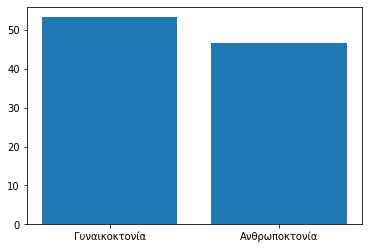

text     0
label    0
dtype: int64

In [332]:
label_distribution = (df['label'].value_counts() * 100) / len(df)
plt.bar(label_distribution.index, label_distribution)
# See class distribution:
plt.show()

# See missing values:
df.isna().sum()

## Split data set to train, validate and test:

In [333]:
# df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=25)

# Split to train validate and test
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [
                                          int(.6*len(df)), int(.8*len(df))])

print(f"No. of training examples: {df_train.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")
print(f"No. of validatig examples: {df_validate.shape[0]}")

# Get X_train, y_train, X_val, y_val, X_test, y_test

X_train = df_train['text']
y_train = df_train['label']

X_val = df_validate['text']
y_val = df_validate['label']

X_test = df_test['text']
y_test = df_test['label']

No. of training examples: 207
No. of testing examples: 69
No. of validatig examples: 69


## Build some Pipelines:

### Naive Bayes:

In [334]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

cfmtx = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
                     'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx

               precision    recall  f1-score   support

Ανθρωποκτονία       1.00      0.71      0.83        31
Γυναικοκτονία       0.81      1.00      0.89        38

     accuracy                           0.87        69
    macro avg       0.90      0.85      0.86        69
 weighted avg       0.89      0.87      0.87        69



,Ανθρωποκτονία,Γυναικοκτονία
Ανθρωποκτονία,22,9
Γυναικοκτονία,0,38


### Linear Support Vector Machines:

In [335]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_val)
np.mean(predicted == y_val)

print(metrics.classification_report(y_val, predicted))

cfmtx = pd.DataFrame(metrics.confusion_matrix(y_val, predicted), index=[
                     'Ανθρωποκτονία', 'Γυναικοκτονία'], columns=['Ανθρωποκτονία', 'Γυναικοκτονία'])

cfmtx

               precision    recall  f1-score   support

Ανθρωποκτονία       0.90      0.90      0.90        31
Γυναικοκτονία       0.92      0.92      0.92        38

     accuracy                           0.91        69
    macro avg       0.91      0.91      0.91        69
 weighted avg       0.91      0.91      0.91        69



,Ανθρωποκτονία,Γυναικοκτονία
Ανθρωποκτονία,28,3
Γυναικοκτονία,3,35
